This Project is recommended to be viewed on this [site](http://nbviewer.jupyter.org/github/NicoBrun/ada2017/blob/master/project/Project.ipynb).

# Sections
* [1. Introduction](#introduction)
* [2. Data gathering](#data)
* * [2.1 Amazon dataset](#amazon)
* * [2.2 scraping Wikipedia](#wikipedia)
* * [2.3 Amazon Product API](#amazonapi)
* [3. What's next for Milestone #3](#milestone3)
* [3. Data analysis]()
* * [3.1 Description]()
* * [3.2 Matching subjects and Controls]()
* * [3.3 Model analysis]()
* * * [3.3.1 Reviews Trend]()
* * * [3.3.2 Actor Analysis]()
* * * * [3.3.2.1 Actor Controls]()
* * * * [3.3.2.2 Actor Subjects]()
* * * * [3.3.2.3 Merge and P Value]()
* * * [3.3.3 Musician analysis]()
* * * * [3.3.2.1 Musician Controls]()
* * * * [3.3.2.2 Musician Subjects]()
* * * * [3.3.2.3 Merge and P Value]()
* * * [3.3.4 Particular case (famous death)]()
* [4. Results and Conclusion]()

In [1]:
#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#scraping imports
import requests
from bs4 import BeautifulSoup

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

#Math
from math import floor

#String matching
import re

# Date
import datetime as dt

# Sleep
import time

# Strict JSON conversion
import json 
import gzip 

# Progress display
from IPython.display import clear_output

# Amazon API querying
from amazon.api import AmazonAPI
from amazon.api import AsinNotFound

#garbage collector
import gc

#p value calculation
from scipy import stats

datapath = 'DATA/review/'

<a id='introduction'></a>
# 1. Introduction

## Abstract

It is often said, ironically, that Van Gogh never sold a painting in his lifetime while he is one of the most famous painters in history.
Is this an isolated case? Is it possible that society has a greater interest in the works of deceased personalities rather than those of their contemporaries? And if so, is this interest more marked when the news is still fresh?
The following project aims to analyze the effect of artists / authors’ death on sales of their own work. 
It starts with the hypothesis that a real societal phenomenon exists, which we will call "post-mortem worship", according to which people feel more interested in the works of artists / authors after their recent decease.
The second assumption, is that this phenomenon can be reduced to the artistic and literary community, which are those concerned with mass celebrity. The last assumption is that the current means of communication allow the whole society concerned, in this case American, to know the news few time after the event. Especially if it is about well-known people.

By working on data from Amazon, the giant of online commerce, and Wikipedia, the most famous encyclopedia of the web, it is possible to test the post-mortem worship effect.
Indeed, the first part of this project consisted of the extraction of the data of interest from Amazon and Wikipedia. This required to filter Amazon data to contain only the required cathegories, clean it and store it in a convenient format for future implementations.
Otherwise, the list of authors deceased in the time interval corresponding to Amazon's data, was scrapped from Wikipedia and stored in a compact and easy-to-use format.  
The second part of the research will be based on the extraction of quantifiable features (interest in the form of number of reviews, appraisal index of reviews, temporal dimensionnality...) in order to allow a mathematical analysis of the data.
The last conclusions will be drawn based on mathematical results and hypothesis testing.


## Research questions
* When a author/artist died, What trend of popularity occurs on their related product on amazon? (For an author; it's book, for an actor; related movies,... etc)
* What's this impact in function of the type of artwork the author/artist did? (musics/books/films/...)


## Dataset
We want to use the Amazon datasets provided in the course, both the review and the metadata dataset. (So at most 20 + 3.1 gb in Json). 
But we will use only specific categories related the creation by an author/artist. (musics/books/films/...)
Since we're very interested in the amount of reviews as a metric of interest, we will restrict our data to the 5-core dataset, as to have at least a few reviews per product.
The interest rate in function of time will be computed with the help of the review content and their dates. (text analysis)
To correlate this interest rate, we will need artists'/authors' death and their corresponding work. For this we will use Wikipedia and scrap the useful data needed for our project.
One hard part will be to match  the works of an artist/author to corresponding product on amazon. 


## A list of internal milestones up until project milestone 2
* Define the useful feature inside all the dataset
* Select the categories of product in Amazon containing works of authors/artists (Amazon has 24 categories of item)
* Scrap the death of artists/authors of the N last years, match it with all it's work, then match it with all corresponding amazon product.
* Clean the data
* Think about how to present the project in term of data visualization

---

<a id='data'></a>
# 2. Data gathering

<a id='amazon'></a>
## 2.1 Amazon Dataset

Amazon has a lot of categories:

Books, Electronics, Movies and TV, CDs and Vinyl, Clothing (Shoes and Jewelry), Home and Kitchen, Kindle Store, Sports and Outdoors, Cell Phones and Accessorie, Health and Personal Care, Toys and Games, Video Games, Tools and Home Improvement, Beauty, Apps for Android, Office Products, Pet Supplies, Automotive, Grocery and Gourmet Food, Patio (Lawn and Garden), Baby, Digital Music, Musical Instruments, Amazon Instant Video


### For our project we consider the useful categories as:
* Books
* Movies and TV
* CDs and Vinyl
* Kindle Store
* Digital Music
* Amazon Instant Video

#### Potentially useful
* Toy and Games
* Video Games

---
We can acess the amazon detaset review [here](http://jmcauley.ucsd.edu/data/amazon/links.html).

##### Authors
* [Books](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz)
* [Kindle Store](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz)

##### Actors
* [Movies and TV](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz)
* [Amazon Instant Video](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz)

##### Musician
* [CDs and Vinyl](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_CDs_and_Vinyl_5.json.gz)
* [Digital Music](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz)


#### Metadata (list of all the product with its description)
* [Books](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Books.json.gz)
* [Kindle Store](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Kindle_Store.json.gz)
* [Movies and TV](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Movies_and_TV.json.gz)
* [Amazon Instant Video](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Amazon_Instant_Video.json.gz)
* [CDs and Vinyl](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_CDs_and_Vinyl.json.gz)
* [Digital Music](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Digital_Music.json.gz)
---

In [2]:
#data = pd.read_json(data_path+'Kindle_Store_5.json', lines=True)

Right now we don't use the amazon dataset review at all; for the milestone #2 we only gather the data from wikipedia and amazon product api, to have to tools to do our analysis.

Note that the files are at most 2GB, we can analyse them separately. Therefore, we don't have to use SPARK.

<a id='wikipedia'></a>
## 2.2 scraping Wikipedia

We want to scrap all the musicians, actors and authors that died from 1994 to 2016, from wikipedia. Since we want the most notorious ones, we will scrap from [year's summary page](https://en.wikipedia.org/w/index.php?title=2000#Deaths), and not from the specific ["death in 'year'" page](https://en.wikipedia.org/wiki/Deaths_in_2000) (exemple for 2000).

We will iterate for each wanted year page, and scrap the celebrity's name, birth date, description, and death date.

In [3]:
# Function that matchs a line of the wikitext and return an array of tuples: 
# (person_death_date, person_name, person_description, person_birth_date)
# debug = True return the intermediary matching
def matchLine(line, debug=False):
    if debug:
        print(line)
    #match when a line contains only 1 celebrity
    match_1_line = re.match( r'.*\[\[(.*?)\]\] (&ndash;|-|–).*?\[\[(.*?)\]\](.*)\(b\..*\[\[(.*?)\]\]\)', line)
    if match_1_line:
        if debug:
            print(match_1_line)
        return [(match_1_line.group(1),match_1_line.group(3),match_1_line.group(4),match_1_line.group(5))]
    #didn't find a match for 1 celebrity
    else:
        result = []
        #consider it's a line with multiple celebrities dead on the same day, separated by \n**
        s = line.split("\n**")
        #if the split didn't work, we return a matching error:
        if len(s)==1:
            print("No match found for: "+ str(year) +" "+ line)
        #the first split contains only the death date
        match_date = re.match( r'\[\[(.*)\]\]',s[0]).group(1)
        #iterate for each celebrities
        for i in range(1,len(s)):
            match_3_param = re.match( r'.*\[\[(.*?)\]\](.*)\(b\. ?\[\[(.*?)\]\]\)', s[i])
            if debug:
                print(match_3_param)
            #if the match is succesful, add the celebrity to the array
            if match_3_param and match_date:
                result.append((match_date,match_3_param.group(1),match_3_param.group(2),match_3_param.group(3)))
            #otherwise return a matching error
            else:
                print("No match found for: "+ str(year) +" "+ s[i])
        return result

In [4]:
month_list = ['January', 'February', 'March', 'April', 'May', 
              'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Function that return a standardized date in string %year-%month-%day
def computeDate(year, md):
    a = md.split(" ")
    if a[0] in month_list:
        month = month_list.index(a[0])+1
        day = a[1]
        return str(year)+"-"+str(month).zfill(2)+"-"+str(day).zfill(2)
    #return an date error that we couldn't convert
    else:
        print("Date error: "+md+" "+str(year));
        return np.nan

In [5]:
#create an empty dataFrame
columns = ['Death Date', 'Name', 'Description','Birth Date']
df = pd.DataFrame(columns=columns) 

#the year of the interval of the amazon dataset
starting_year = 1996
ending_year = 2014

#every year we scrap the corresponding wikipedia page
for year in range(starting_year,ending_year+1):
    #we retrieve only the wikitext using the parameter action=raw
    #note that the api documentation advise to do this way if we are interested only by the wikitext
    year_url = "https://en.wikipedia.org/w/index.php?action=raw&title={}&maxlag=5".format(year)
    r = requests.get(year_url)
    page_text = r.text
    #we split the text to retrieve only the part about celebrities' deaths
    if("== Deaths ==" in page_text):
        a = page_text.split("== Deaths ==")[1]
    elif("==Deaths==" in page_text):
        a = page_text.split("==Deaths==")[1]
    else:
        a = None
    #we set our starting text at the first month (i.e January)
    if("=== January ===" in page_text):
        a = a.split("=== January ===")[1]
    elif("===January===" in page_text):
        a = a.split("===January===")[1]
    else:
        a = None
    #all the month are separated by \n\n, so we split and iterate over the 12
    deaths = a.split("\n\n")
    for i in range(12):
        #We have 2 case: 1 celebrity per date, or multiple celebrity per date, so we split in consequence,
        #then we match the line into groups using pattern recognition.
        s = deaths[i].split('* ',1)[1]
        lines = s.split("\n* ")
        for line in lines:
            res = matchLine(line)
            for person in res:
                    #when we finished matching, we format the date, then add the celebrity into the dataFrame
                    date = computeDate(year,person[0])
                    df.loc[len(df)]=[date,person[1]," "+person[2].lower(),person[3]]
print(df.shape)
df.head(10)

No match found for: 1996  Victims of [[TWA Flight 800]]
No match found for: 2001  2,996 people (2,977 victims and 19 hijackers) who died in the [[September 11 attacks]]
No match found for: 2013 [[April 30]] (death announced on this date) &ndash; [[Deanna Durbin]], Canadian-born singer and actress (b. [[1921]])
(3327, 4)


,Death Date,Name,Description,Birth Date
0,1996-01-01,Malladihalli Sri Raghavendra Swamiji,", indian yogi",1890
1,1996-01-01,Moshe Aryeh Freund,", israeli rabbi",1894
2,1996-01-01,Arleigh Burke,", american naval officer",1901
3,1996-01-01,Arthur Rudolph,", german rocket engineer",1906
4,1996-01-02,Karl Targownik,", hungarian psychiatrist and holocaust survivor",1915
5,1996-01-05,Yahya Ayyash,", palestinian shaheed",1966
6,1996-01-05,Lincoln Kirstein,", american writer and impresario",1907
7,1996-01-05,Richard Versalle,", american operatic tenor",1932
8,1996-01-07,Prime Minister of Hungary,,1930
9,1996-01-07,Tarō Okamoto,", japanese artist",1911


The matcher has only 3 errors over 3313 matching, which is a good result.
Most of those error is just a special change of format in the list, where they listed celebrities inside specific tragedies.
In this case we will add them manually.

In [6]:
#we add only wanted celebrity (singer, actor,...)
#TWA Flight 800
df.loc[len(df)]=["1996-07-17","Marcel Dadi",", French guitarist".lower(),"1951"]
df.loc[len(df)]=["1996-07-17","David Hogan",", American composer".lower(),"1949"]
#Deanna Durbin
df.loc[len(df)]=["2013-04-30","Deanna Durbin",", Canadian-born singer and actress".lower(),"1921"]

We consider to multi-index on name and birth date.
Then we order them in fuction of their death date.

In [7]:
df2 = df.set_index(['Name', 'Birth Date'])
print("Index is unique: "+str(df.index.is_unique))
df2.sort_values('Death Date',inplace = True)
df2.head()

Index is unique: True


,,Death Date,Description
Name,Birth Date,,
Malladihalli Sri Raghavendra Swamiji,1890,1996-01-01,", indian yogi"
Moshe Aryeh Freund,1894,1996-01-01,", israeli rabbi"
Arleigh Burke,1901,1996-01-01,", american naval officer"
Arthur Rudolph,1906,1996-01-01,", german rocket engineer"
Karl Targownik,1915,1996-01-02,", hungarian psychiatrist and holocaust survivor"


Then we removed the celebrities which died outside of the interval of the Amazon dataset (May 1996 - July 2014).

In [8]:
df2 = df2[(df2['Death Date'] >= '1996-05-01') & (df2['Death Date'] <= '2014-07-31')]
df2.tail(5)

,,Death Date,Description
Name,Birth Date,,
David Easton,1917,2014-07-19,", canadian-american political scientist"
James Garner,1928,2014-07-19,", american actor"
Carlo Bergonzi,1924,2014-07-25,", italian tenor and actor"
Francesco Marchisano,1929,2014-07-27,", italian cardinal"
Julio Grondona,1931,2014-07-30,", argentinian football authority"


Now we want to keep only **musicians, actors or authors.**
Since we have a small description of the celebrity, it's trivial that the description will contains his job if the celebrity is famous by his job. 
_Note that some celebrities doesn't have a description, it's the case when their name contains the description: president, prince, king,...etc._

We match a celebrity if he is a musician, actor or author if it contains a specific keyword, for example: _"actor"_.

In [9]:
df3 = df2

#return true if the description contains one of this keywork
jobMusician = ["dj","baritone","bard","pianist","singer","tenor ","soprano", "composer","trumpeter","saxophonist","lyricist", "drummer", "musician", "rapper","guitarist","violinist","violist","bassist"]
def isMusician(s):
    for job in jobMusician:
        if job in s:
            return True
    return False

#return true if the description contains one of this keywork
jobActor = ["actor", "actress","filmmaker","cinematographer","film director", "film producer"]
def isActor(s):
    for job in jobActor:
        if job in s:
            return True
    return False

#return true if the description contains one of this keywork
jobAuthor = ["autor", "author", "writer", "poet", "novelist","cartoonist","comic strip artist","manga artist"]
def isAuthor(s):
    for job in jobAuthor:
        if job in s:
            return True
    return False

#add 3 column to the data frame: Actor, author and Musician. It's possible that someone is both, so they all have those 3 booleans parameters.
df3 = df3.merge(df3.Description.apply(lambda s: pd.Series({'Musician':isMusician(s), 'Actor':isActor(s), 'Author':isAuthor(s)})), 
    left_index=True, right_index=True) 

#filter only actor author or musician
df_artists = df3[(df3['Actor'] == True) | (df3['Author'] == True) | (df3['Musician'] == True)]
df_artists = df_artists.sort_values('Death Date')

print("Number of celebrities: "+str(df.shape[0]))
print("Number of useful celebrities: "+str(df_artists.shape[0]))
print("Number of unwanted celebrities: "+str(df.shape[0]-df_artists.shape[0]))

#print only the wanted celebrities
df_artists.head(5)

Number of celebrities: 3330
Number of useful celebrities: 1321
Number of unwanted celebrities: 2009


,,Death Date,Description,Actor,Author,Musician
Name,Birth Date,,,,,
Jack Weston,1924,1996-05-03,", american actor",True,False,False
John Beradino,1917,1996-05-19,", american baseball player and actor",True,False,False
Jon Pertwee,1919,1996-05-20,", british actor",True,False,False
Paul Delph,1957,1996-05-21,", american musician and producer",False,False,True
Lash LaRue,1917,1996-05-21,", american actor",True,False,False


We save this DF, since wikipedia pages are edited frequently.

In [10]:
df_artists.to_csv('DATA/deaths.csv')

<a id='amazonapi'></a>
## 2.3 Amazon Product API

Now we want to link an amazon product to celebrities it is related to : book's authors, film's actors and directors, music's artist. 

Our first idea was to scrap his works from their personnal Wikipedia page, and scrap all their works. For example, for an actor, we would scrap the subsection "Filmography" and read the corresponding tables in its subsections to find the link between the actor and his films.

However there exists an [Amazon product API](http://docs.aws.amazon.com/AWSECommerceService/latest/DG/becomingDev.html) that does the hard work for us. When you give a product ID (ASIN), the api will return a wrapper object, that contains field values for **directors, actors, authors, creators**. It's perfect for us! This way we will filter the products related to our artists list.

As to the implementation, it is identical for each categories, but it takes a long time to run, as amazon requires that API users throttle their requests in order not to flood their servers.  
We query all the necesary ASINs, then save the resulting dataframe to a .csv file. For this reason, we will show the code we used to gather the artists for the 'Movies and TV' category - it can be generalized to all other categories - and simply load the results we obtained for the other categories.

In [11]:
filename = 'meta_Movies_and_TV.json.gz'
features = ['asin', 'title', 'description']
df_name = "meta_Movies_and_TV"

In [2]:
## Load all ASINs we're going to query - use the metadata files
## for this, as they contains each ASIN once and only once.
##

''' This function was provided on the amazon dataset's webpage
    It loads a gzipped file directly into a dataframe
'''
def gz_to_dataframe(datapath, filename):
    def parse(path): 
        g = gzip.open(path, 'rb') 
        for l in g: 
            yield eval(l) 
    def getDF(path): 
        i = 0 
        df = {} 
        for d in parse(path): 
            df[i] = d 
            i += 1 
        return pd.DataFrame.from_dict(df, orient='index') 
    return getDF(datapath+filename)

In [13]:
amazon_products_df = gz_to_dataframe(datapath, filename)[features]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-69465d49bdf6>", line 1, in <module>
    amazon_products_df = gz_to_dataframe(datapath, filename)[features]
  File "<ipython-input-12-8dda643e11a0>", line 20, in gz_to_dataframe
    return getDF(datapath+filename)
  File "<ipython-input-12-8dda643e11a0>", line 16, in getDF
    for d in parse(path):
  File "<ipython-input-12-8dda643e11a0>", line 10, in parse
    g = gzip.open(path, 'rb')
  File "C:\ProgramData\Anaconda3\lib\gzip.py", line 53, in open
    binary_file = GzipFile(filename, gz_mode, compresslevel)
  File "C:\ProgramData\Anaconda3\lib\gzip.py", line 163, in __init__
    fileobj = self.myfileobj = builtins.open(filename, mode or 'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'DATA/review/meta_Movies_and_TV.json.gz'

During handling of the abo

FileNotFoundError: [Errno 2] No such file or directory: 'DATA/review/meta_Movies_and_TV.json.gz'

In [ ]:
## Sign in with amazon API 
##

def get_amazon_interface():
    f = open("api_creds")
    ar = f.read().split("\n")
    return AmazonAPI(ar[0], ar[1], ar[2])
    return ar[0], ar[1], ar[2]

amazon = get_amazon_interface()

In [ ]:
## Here, we define some API query helpers
##

''' Product lookup with API, asin can be a string ('one by one' lookup)
    or a list of strings ('bulk lookup').
    bulk lookup provides better performance
'''
def get_prod(asin) : 
    if not isinstance(asin, str): 
        acc_str = asin[0]
        for e in asin : 
            acc_str += ','+e
        print(acc_str)
        return amazon.lookup(ItemId=acc_str)
    else :
        return amazon.lookup(ItemId=asin)
    
''' Splits the interval [start-end] into bulks of size bulksize
'''    
def gen_bulk_index(start, end, bulksize=10, includeEnd=False):
    size = end - start + 1
    bulks = [list(range(start+(i*bulksize), start + (i+1)*bulksize)) for i in range(0, int(size/bulksize))]
    if includeEnd : 
        bulks.append(list(range(bulks[len(bulks)-1][bulksize-1], end+1)))
    else : 
        bulks.append(list(range(bulks[len(bulks)-1][bulksize-1], end)))
    return bulks    

''' Helper : extracts wanted data from the amazon product 'amazonProduct' and 
             puts it in the dataframe at the given positions   
'''
def set_df_cell_from_product(amazonProduct, rowNumber, fieldName1, fieldName2) :
    if (amazonProduct is None) : 
        product_df.set_value(rowNumber, fieldName1, [])
        product_df.set_value(rowNumber, fieldName2, [])     
    else : 
        actors = get_actors(amazonProduct)
        product_df.set_value(rowNumber, fieldName1, actors)
        directors = get_directors(amazonProduct)
        product_df.set_value(rowNumber, fieldName2, directors)


def get_directors(prod) : 
    return prod.directors

def get_actors(prod) : 
    return prod.actors


In [ ]:
## Also, we have some functions to save the state of our data structure - in case we need to 
## to shutdown the computer and restart the query loop at a later time (not used here)
##

def save_progress(dataframe, nb_rows_processed):
    dataframe.to_csv(datapath+df_name+"temp.csv")
    file = open(datapath+df_name+"progress", "w")
    file.write(str(nb_rows_processed))

    
def load_progress():
    dataframe = pd.read_csv(datapath+df_name+"_temp.csv")
    file = open(datapath+df_name+"progress", "r")
    nb_rows_processed = file.readline()
    return dataframe, int(nb_rows_processed)


To improve performance by limiting network IO, the API allows "bulk querying. We will use this feature, however, we found out the some query in the bulk could "fail silently" : you can query for 10 ASINs, and receive a list of only 8 responses, while if you query each ASIN independantly, a AsinNotFound exception would be raised for the two missing products.   
To make up for that, we use bulk querying, but fall back to 'one-by-one' querying in case of errors. We also exploited the notebook "variables are kept intact inbetween cell runs" to save our results in case of unexpected network error, instead of putting all our code in a try/catch block, since network errors happened very rarely with proper throttling parameter.

In [ ]:
## Parameters & initialization for bulk item lookup
##

bulksize = 10

# Change this to restore progress from file
fresh_run = True

if fresh_run : 
    # used to restart from where we were in case of unexepected network error
    lastItemLookedUp = 0
    amazon_products_df['actors'] = pd.Series(dtype=object)
    amazon_products_df['directors'] = pd.Series(dtype=object)
else : 
    amazon_products_df, lastItemLookedUp = load_progress()
    
print("last item looked up : ", lastItemLookedUp,  "  -  time : ",time.strftime("%H:%M:%S"), "\n\n")

In [ ]:
## Querying loop
##

original_lastItemLookedUp = lastItemLookedUp


for bulk in gen_bulk_index(lastItemLookedUp, amazon_products_df.shape[0], bulksize=bulksize) : 
    # display progess
    if ((bulk[0]-(original_lastItemLookedUp)) % 100 == 0) : 
        clear_output()
        print("    ",int(100 * (bulk[0]+1) / amazon_products_df.shape[0]), "% completed (",bulk[0], " rows)", "  -  time : ",time.strftime("%H:%M:%S"))
        print("     Last Item Looked up : ", lastItemLookedUp, " / ", amazon_products_df.shape[0])
        print("\n\n\n")
    
    # get asins for the bulk and fetch the matching AmazonProducts
    asins = amazon_products_df['asin'][bulk].tolist()
    prods = get_prod(asins)

    # Then, process each product to add necessary informations in the dataframe
    if (type(prods) is list) and (len(prods) == bulksize) :              
        # Case : we found exactly one result per ASIN
        #        process by bulk
            for i, prod in enumerate(prods) : 
                set_df_values_from_product(prod, bulk[i], "actors", "directors")
    elif (type(prods) is list) or (type(prods) is AmazonApi.AmazonProduct) :  
        # Case : we obtained a list of AmazonProducts or a single AmazonProduct
        #        fallback to 1-by-1 querying
        for n in bulk :               
            asin = product_df['asin'][n]
            try : 
                prod = get_prod(asin)
            except(AsinNotFound): 
                prod = None
            set_df_values_from_product(prod, n, "actors", "directors")
            time.sleep(0.15)
        
    # Save progress
    lastItemLookedUp = bulk[bulksize-1]
        
    # limit query frequency to avoid 503 errors
    time.sleep(min(bulksize/10, 5))

We can then write the resulting dataframe to file, and re-use it later by simply loading the file

In [ ]:
amazon_products_df.to_csv(datapath+df_name+".csv")
del amazon_products_df  # free memory

Since the command takes a while to run, and we had ran it before, we interrupted it manually, but we can load the results directly from the csv file we obtained then. It will work similarily with the other metadata files once we process them

In [6]:
obtained_dataframe = pd.read_csv("DATA/meta_Movies_and_TV_processed.csv")
obtained_dataframe.head(10)

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,asin,categories,description,salesRank,actors,directors
0,0000143561,"[['Movies & TV', 'Movies']]","3Pack DVD set - Italian Classics, Parties and ...",{'Movies & TV': 376041},[],[]
1,0000589012,"[['Movies & TV', 'Movies']]",NaN,{'Movies & TV': 1084845},[],[]
2,0000695009,"[['Movies & TV', 'Movies']]",NaN,{'Movies & TV': 1022732},[],[]
3,000107461X,"[['Movies & TV', 'Movies']]",NaN,{'Movies & TV': 954116},['Douglas Miller'],[]
4,0000143529,"[['Movies & TV', 'Movies']]",Disc 1: Flour Power (Scones; Shortcakes; South...,{'Movies & TV': 463562},['Alton Brown'],[]
5,0000143502,"[['Movies & TV', 'Movies']]",Rise and Swine (Good Eats Vol. 7) includes bon...,{'Movies & TV': 467172},['Alton Brown'],[]
6,0000143588,"[['Movies & TV', 'Movies']]",Barefoot Contessa Volume 2: On these three dis...,{'Movies & TV': 309405},['Ina Garten'],[]
7,0001517791,"[['Movies & TV', 'Movies']]",Praise Aerobics - A low-intensity/high-intesit...,{'Movies & TV': 557724},[],[]
8,0001527665,"[['Movies & TV', 'Movies']]",NaN,{'Movies & TV': 734524},[],[]
9,0001516035,"[['Movies & TV', 'Movies']]",Worship with Don Moen [VHS],{'Movies & TV': 435882},[],[]


---

<a id='milestone3'></a>
# 3. What's next for Milestone #3

Currently we have all the review for each product, the list of celebrities and the list of product linked with celebrities name.
We will mix everything together and analyse the patterns of review (date, rating,...etc) for each given artist and draw conclusions from it.

*** We still want to answer those questions:***
* When a author/artist died, What trend of popularity occurs on their related product on amazon? (For an author; it's book, for an actor; related movies,... etc)
* What's this impact in function of the type of artwork the author/artist did? (musics/books/films/...)

*** Summary of the future work ***

First, it is necessary to filter the reviews data by matching each cathegorized reviews data with the corresponding dead artist:

- match movies reviews and dead actors, movies reviews and dead realisators, kindle store/book reviews and dead authors, CDs/Vinyl/Digital music reviews and dead musicians

- this will be done thanks to the informations obtained about the dead artists names (Wikipedia), the artists products (Amazon API) and the products reviews (Amazon review data)

Here is a little example of the type of data we wish to produce when matching dead actors with their movies and the correpsonding costumer reviews:
It was performed with the current data (but only 100 dead actors). It needs to be extended to all the different categories and all the dead actors. 

In [14]:
sample_movies_actors = pd.read_csv('movie_reviews_matched_sample.csv')
sample_movies_actors.set_index(['actor name',
                                'death date',
                                'title',
                                'categories','ReviewTime']).drop(['asin','Unnamed: 0'],axis=1).head()

reviewText  \
actor name  death date title                   categories          ReviewTime                                                      
Jack Weston 1996-05-03 The Thomas Crown Affair Movies & TV, Movies 2006-04-07  The Original and the best-not much to say read...   
                                                                   2013-03-24  This was a great movie Steve McQueen invented ...   
                                                                   2014-04-05  Everybody knows banks, whether in storefronts,...   
                                                                   2012-12-21  an all-time great movie and one of my favorite...   
                                                                   2013-05-12  Fans of a rough and tough McQueen know that th...   

                                                                                                               summary  
actor name  death date title                   categories          ReviewTime                                           
Jack Weston 1996-05-03 The Thomas Crown Affair Movies & TV, Movies 2006-04-07                              The orginal  
                                                                   2013-03-24              Steve McQueen invented cool  
                                                                   2014-04-05                       Where The Dough Is  
                                                                   2012-12-21  great movie,but PLEASE avoid this copy.  
                                                                   2013-05-12                             It's McQueen

*** Once each final matched data will be generated, different quantifiable features have to be extracted and the data filtered: ***

1) Filtering:*** 

- keep only the artists which allow an unbiased analysis, i.e with enough total reviews and comparable time availability of reviews before and after death

2) Extracting features:*** 

- compute the average ratings before and after death
- compute the number of reviews before and after death
- look for mentions showing interest for the artist, or interest for its recent death in the reviews text
- compare the before/ after results with statistical tests
- make the analysis at a higher level: per-cathegory results, global result

*** At the end, the results will be summarized and properly displayed. ***

# 3'. Milestone #3

## Summary:

We wanted to analyse Actor, Musician and Writer. However our work depends of the Amazon Product API and retrieving the required data for the books categories would take at least 1 month because of the request rate. For this reason we dropped our analysis about writer and focus on Actor and Musician.
This was our only problem for milestone 3.

# 3''. Data analysis

## 3.1 Description

## 3.2 Matching subjects and Controls

## 3.3 Model Analysis

### 3.3.1 Review Trend

We would like to know the trend of all the reviews grouped by our 2 categories: Film for actor and Music for musician.

In [152]:
jsonNameFilm = ['reviews_Amazon_Instant_Video_5.json.gz',
          'reviews_Movies_and_TV_5.json.gz']

jsonNameMusic = ['reviews_CDs_and_Vinyl_5.json.gz'#,
          #'reviews_Digital_Music_5.json.gz'
                ]

We open all the Corresponding reviews db and aggregate them together to have the number of review of each month.

**WARNING:** To run this cell you need at least 8GB of RAM.

In [4]:
#convert a string containing a date into a tuple of year, month, day
def str2Date(s):
    month,day,year = s.split(" ")
    return int(year), int(month), int(day.replace(",",""))

#aggregate the number of review inside all the filenames, and class them in function of the classification 
def computeAgg(filenames, classification = ['year','month']):
    for i,filename in enumerate(filenames):
        print("starting opening: ",filename)
        df = gz_to_dataframe(datapath, filename)
        print("finished opening")
        df['year'], df['month'], df['day'] =  zip(*df['reviewTime'].map(str2Date))
        df2 = df[['year','month','day']]
        #call the garbage collector to prevent "not enough memory error"
        del df
        gc.collect()
        df3 = df2.groupby(classification).size()
        del df2
        gc.collect()
        print("df is appended")
        if i==0:
            b = df3
        else:
            b = b.add(df3, fill_value=0)
    print("finished the aggregation")
    return b 

#compute the popularity of each categorie
popularityReviewFilm = computeAgg(jsonNameFilm)
popularityReviewMusic = computeAgg(jsonNameMusic)

starting opening:  reviews_Amazon_Instant_Video_5.json.gz
finished opening
df is appended
starting opening:  reviews_Movies_and_TV_5.json.gz
finished opening
df is appended
finished the aggregation
starting opening:  reviews_CDs_and_Vinyl_5.json.gz
finished opening
df is appended
finished the aggregation


We see that the amount of review is far more important for the Film. The trend is pretty stable until 2012, where we see a high growth of review per month. It's probably because internet become more omnipotent in our life at this specific time. Another factor is that amazon become very popular as a site from 2012 until now. Films grow a lot more than the music in this period.

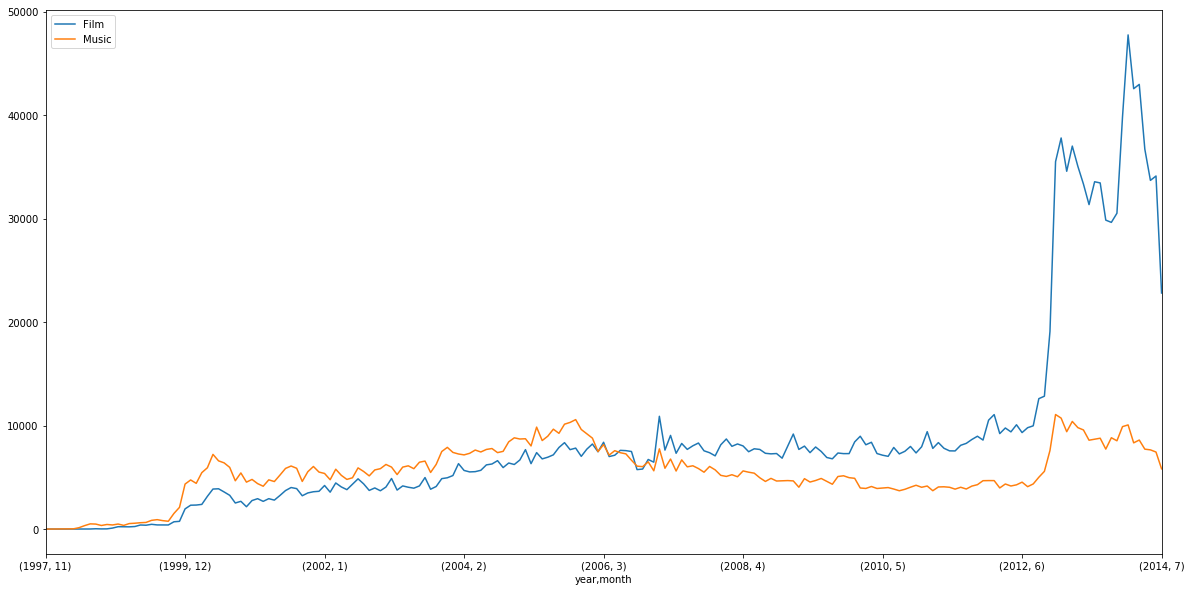

In [169]:
popularityReviewFilm.plot(x="year,month", y="Film review", figsize=(20,10), legend ='film',label = 'Film')
popularityReviewMusic.plot(x="year,month", y="Music review", figsize=(20,10), legend = 'music',label = 'Music')

We want to normalize the weight of review base of the time it was written. The reason is that we would notices the trend in the graph above in our analysis if we were to not normalize at all.

We choose arbitrarly that a review weight exactly 1 in january 2004.
Then all the review we will consider will be scaled by their inverse value in their timestamp multiplied by a factor C.

C = the number of reviews in january 2004.

In [172]:
yearNorm = 2004
monthNorm = 1

yearThreshold = 2000

def computeInv(popularityReview,yearNorm,monthNorm):
    normreviews = popularityReview.loc[yearNorm,monthNorm]
    return popularityReview.copy().apply(lambda x: normreviews/x)
     

scalingReviewFilm = computeInv(popularityReviewFilm,yearNorm,monthNorm)
scalingReviewFilm = scalingReviewFilm.loc[scalingReviewFilm.index.get_level_values(0) > yearThreshold]

scalingReviewMusic = computeInv(popularityReviewMusic,yearNorm,monthNorm)
scalingReviewMusic = scalingReviewMusic.loc[scalingReviewMusic.index.get_level_values(0) > yearThreshold]

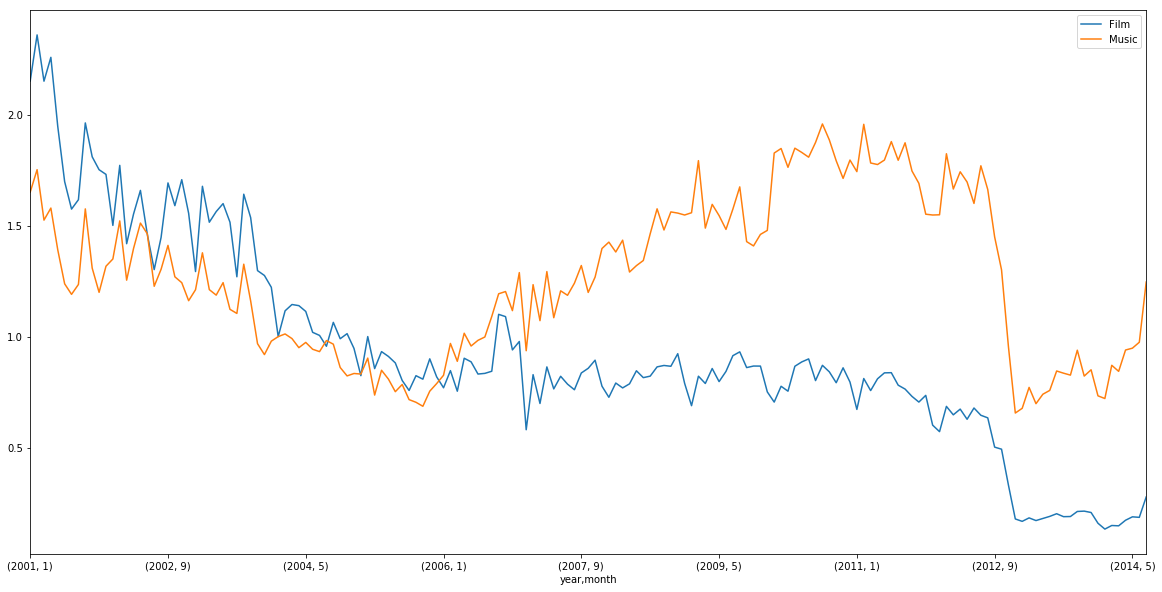

In [174]:
scalingReviewFilm.plot(figsize=(20,10),legend ='film',label = 'Film')
scalingReviewMusic.plot(figsize=(20,10),legend = 'music',label = 'Music')

### 3.3.2 Actor Analysis

In [7]:
def dateAddMonth(date,month_to_add):
    year, month, day = date.split("-")
    year, month, day = int(year), int(month), int(day)
    month = month_to_add + month
    year+= floor(month/12)
    month=month%12
    if(month==0):
        month=12
        year-=1
    return str(year)+"-"+str(month).zfill(2)+"-"+str(day).zfill(2)

def sampledReviewForActorInTimestamp(df,actor,death_date,month_before,month_after):
    actors =  df['actor name'] == actor
    upperDate = dateAddMonth(death_date,month_after)
    lowerDate = dateAddMonth(death_date,-month_before)
    dateLowerBound = df['reviewTime']>lowerDate
    dateUpperBound =df['reviewTime']<upperDate 
    return df[actors & dateLowerBound & dateUpperBound]

In [8]:
def computeDiffReviewDateToDeathDate(row):
    yDead, mDead, dDead = row['death date'].split("-")
    yDead, mDead, dDead = int(yDead), int(mDead), int(dDead) 
    yReview, mReview, dReview = row['reviewTime'].split("-")
    yReview, mReview, dReview = int(yReview), int(mReview), int(dReview) 
    return (dt.datetime(yReview,mReview,dReview)-dt.datetime(yDead, mDead, dDead)).days 

In [9]:
def computeReviewsRatingPonderation(df,row):
    yReview, mReview, dReview = row['reviewTime'].split("-")
    yReview, mReview, dReview = int(yReview), int(mReview), int(dReview)
    return df.loc[yReview,mReview]

In [10]:
#return a list of tuples with actors and it's corresponding death date, in case of the control group, return the death date of its corresponding subject
def extractActors(df, yearThreshold, month_before):
    date = str(yearThreshold+1)+"-01-01"
    dateThreshold = dateAddMonth(date,month_before)
    return list(df[df['death date']>dateThreshold].groupby(['actor name','death date']).groups.keys())

In [11]:
def minMention(df,person,threshold_mentions):
    val = df[df['actor name'] == person]['mentionned'].sum()
    return val>=threshold_mentions
def computeNbrReview(df,person):
    return len(df[df['actor name']== person])

In [90]:
def AggAllNormDays(df_person,df_review_popularity,dead_actors,month_before,month_after,threshold_mentions = 0, min_review = 0):
    first = True
    classification = ['year', 'month']
    for actor,death_date in dead_actors:
        has_enough_mention = minMention(df_person,actor,threshold_mentions)
        df2 = sampledReviewForActorInTimestamp(df_person,actor,death_date,month_before,month_after).copy()
        actor_tot_number_review = computeNbrReview(df2,actor)
        if len(df2>0) and has_enough_mention and actor_tot_number_review >= min_review:
            df2['normDays'] = df2.apply(lambda row: computeDiffReviewDateToDeathDate(row),axis=1)
            df2['RatingValue'] = df2.apply(lambda row: computeReviewsRatingPonderation(df_review_popularity, row),axis=1)
            df2 = df2.groupby(['normDays'])['RatingValue'].sum()
            df2 = df2.rename(actor)
            df2 = df2.apply(lambda x: x/actor_tot_number_review)
            if first:
                b = df2
                first = False
            else:
                b = pd.concat([b.reindex(list(range(-30*month_before,30*month_after))).fillna(0), df2], axis=1)
    return  b[b.index < 30*month_after].fillna(0)

#### 3.3.2.1 Actor Subjects

In [13]:
reviewPath = 'DATA/review_filtered/'
df_actor_subject = pd.read_csv(reviewPath+'reviews_subjects_500_actor.csv')
df_actor_subject.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date,reviewYear,reviewTime,death year,mentionned
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03,2006,2006-04-07,1996,False
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03,2013,2013-03-24,1996,False
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03,2014,2014-04-05,1996,False
3,308662,0792840461,2012-12-21,2.0,"[3, 3]","great movie,but PLEASE avoid this copy.",an all-time great movie and one of my favorite...,jack weston,1996-05-03,2012,2012-12-21,1996,False
4,308663,0792840461,2013-05-12,5.0,"[0, 0]",It's McQueen,Fans of a rough and tough McQueen know that th...,jack weston,1996-05-03,2013,2013-05-12,1996,False


2001-07-01


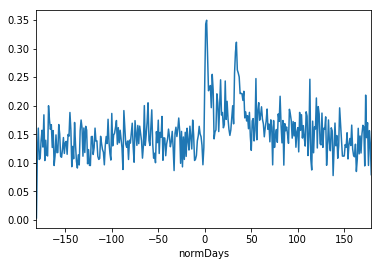

In [106]:
month_before, month_after = 6, 6
min_review = 100

dead_actors = extractActors(df_actor_subject, yearThreshold, month_before)
subject_review_actor = AggAllNormDays(df_actor_subject, scalingReviewFilm, dead_actors, month_before, month_after, min_review = min_review)
subject_review_actor_curve = subject_review_actor.sum(axis=1)
subject_review_actor_curve.plot()

#### 3.3.2.2 Actor Controls

In [109]:
df_actor_control = pd.read_csv(reviewPath+'reviews_controls_500_actor.csv')
df_actor_control.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,reviewYear,reviewTime,mentionned
0,827321,630327417X,2009-10-15,5.0,"[0, 1]",Great Movie,Nothing bad to say. Dvd came quickly and in gr...,michael hynson,2009,2009-10-15,False
1,827322,630327417X,2000-09-16,5.0,"[0, 0]",endless summer,its just to good for words!,michael hynson,2000,2000-09-16,False
2,827323,630327417X,2005-03-03,1.0,"[5, 58]",A very disappointed lover of documentaries,I feel obligated to warn you-as I wish I was w...,michael hynson,2005,2005-03-03,False
3,827324,630327417X,2005-09-23,5.0,"[3, 8]","Si eres surfer de Corazon, te gustara","Excelente pelicula, te sirve para saber el ini...",michael hynson,2005,2005-09-23,False
4,827325,630327417X,2000-06-23,5.0,"[7, 8]",The definitive surfer's movie -- get the feel...,"This movie provides a connection to surf, surf...",michael hynson,2000,2000-06-23,False


In [110]:
matching_subject_actor_control = pd.read_csv(reviewPath+'matchings_500_vectormatched_actor.csv')
matching_subject_actor_control = matching_subject_actor_control[['ctl','death date']].set_index('ctl')

In [111]:
def computeDeathDateCtrl(matching,row):
    actor = row['actor name']
    if actor in matching.index:
        return matching.loc[actor]
    return np.nan

In [112]:
df_actor_control['death date'] = df_actor_control.apply(lambda row: computeDeathDateCtrl(matching_subject_actor_control, row),axis=1)
df_actor_control = df_actor_control.dropna()

In [113]:
df_actor_control['death date'] = df_actor_control['death date'].apply(lambda x: x[0])

In [114]:
alive_actors_control = extractActors(df_actor_control, yearThreshold, month_before)
control_review_actor = AggAllNormDays(df_actor_control, scalingReviewFilm, alive_actors_control, month_before, month_after, min_review = min_review)
control_review_actor_curve = control_review_actor.sum(axis=1)

2001-07-01


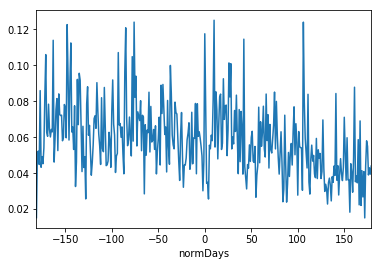

In [115]:
control_review_actor_curve.plot()

#### 3.3.2.3 Merge and P value

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  


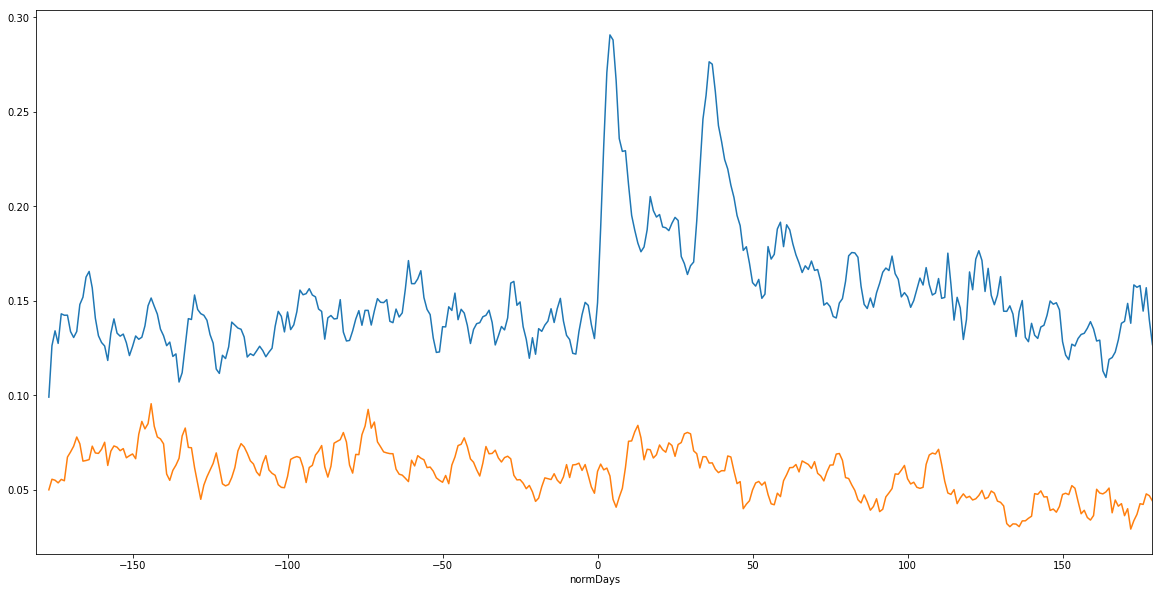

In [117]:
pd.rolling_mean(subject_review_actor_curve,5).plot(figsize=(20,10))
pd.rolling_mean(control_review_actor_curve,5).plot(figsize=(20,10))

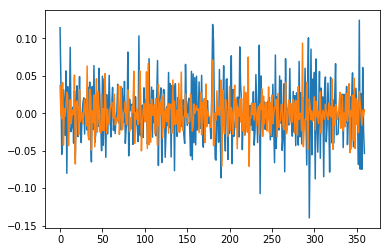

In [118]:
plt.plot(np.diff(subject_review_actor_curve))
plt.plot(np.diff(control_review_actor_curve))

In [119]:
_, p_actor = stats.ttest_ind(subject_review_actor,control_review_actor,axis=1,equal_var=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


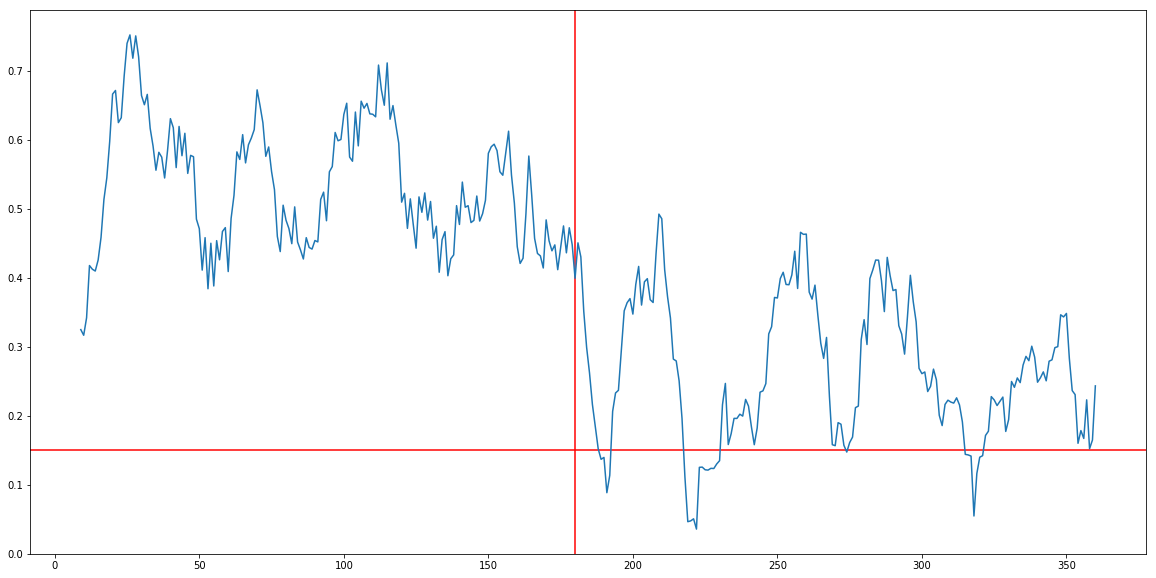

In [150]:
plt.figure(figsize=(20,10))
plt.axhline(y=0.15,color='red')
plt.axvline(x=180,color='red')
#plt.yticks(np.arange(0, 0.2, 0.010))
plt.plot(pd.rolling_mean(p_actor,10))
#plt.plot(p)
x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,0,1))
plt.show()

### 3.3.3 Musician Analysis

In [121]:
df_music_subject = pd.read_csv(reviewPath+'music_reviews_subjects_367.csv')
df_music_subject.head()

,asin,reviewText,summary,strReviewTime,actor name,death date,birth date,reviewYear,reviewTime,death year,mentionned
0,B000KB9Y6U,I bought this item because it did not say vyna...,Should be more descriptive in the title.,2013-05-23,paul delph,1996-05-21,1957,2013,2013-05-23,1996,False
1,B000KB9Y6U,Chrissy Faith is wonderful I must say!! What ...,You should listen this!!,2013-11-09,paul delph,1996-05-21,1957,2013,2013-11-09,1996,False
2,B000KB9Y6U,this product came quickly and there were no is...,great music,2013-04-26,paul delph,1996-05-21,1957,2013,2013-04-26,1996,False
3,B000EU1H44,To put it short - the sounds are very explorat...,Enchanting,2008-07-11,jacob druckman,1996-05-24,1928,2008,2008-07-11,1996,False
4,B000LP4O1K,This is a delightful recording. It's lite enou...,Pleasing,2011-05-19,jacob druckman,1996-05-24,1928,2011,2011-05-19,1996,False


2001-07-01


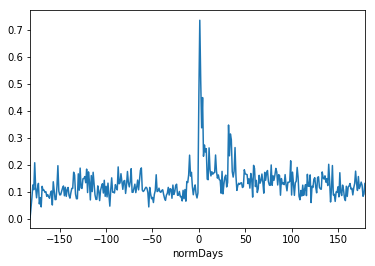

In [122]:
dead_musicians = extractActors(df_music_subject, yearThreshold, month_before)
subject_review_musician = AggAllNormDays(df_music_subject, scalingReviewMusic, dead_musicians, month_before, month_after, min_review = min_review)
subject_review_musician_curve = subject_review_musician.sum(axis=1)
subject_review_musician_curve.plot()

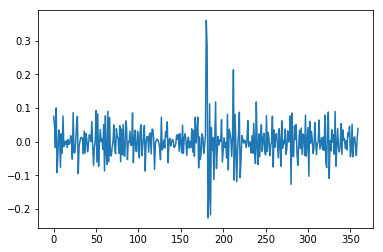

In [123]:
plt.plot(np.diff(subject_review_musician_curve))

In [124]:
df_musician_control = pd.read_csv(reviewPath+'music_reviews_controls_367.csv')
df_musician_control.head()

,asin,reviewText,summary,strReviewTime,actor name,death date,birth date,reviewYear,reviewTime,mentionned
0,B0002VYEHW,"In a reggae universe gone mad for dancehall, T...",Plain good reggae,2005-08-23,tike jah fakoly,unknown,unknown,2005,2005-08-23,True
1,B0002VYEHW,"Tiken Jah's ""Coup de Gueule"" is on the continu...","MBafoh Pian!!!( I Shall Say It Loud and Sound,...",2006-03-10,tike jah fakoly,unknown,unknown,2006,2006-03-10,True
2,B0040AT66U,This is very touching little opera. The libret...,A Mini Masterpiece,2013-05-28,patricia risley,unknown,unknown,2013,2013-05-28,False
3,B0052FG8BS,I was drawn to this recording of Aldridge's El...,Highly praised opera deserves it,2011-09-28,patricia risley,unknown,unknown,2011,2011-09-28,False
4,B0052FG8BS,"The Christian ""revivalist"" movement and the hi...","Very ""American"" opera a welcome addition!",2011-08-15,patricia risley,unknown,unknown,2011,2011-08-15,True


In [125]:
matching_subject_musician_control = pd.read_csv(reviewPath+'music_matchings_367_feature=yearbefore.csv')
matching_subject_musician_control = matching_subject_musician_control[['ctrl_name','death date']].set_index('ctrl_name')

In [126]:
df_musician_control['death date'] = df_musician_control.apply(lambda row: computeDeathDateCtrl(matching_subject_musician_control, row),axis=1)
df_musician_control = df_musician_control.dropna()
df_musician_control

,asin,reviewText,summary,strReviewTime,actor name,death date,birth date,reviewYear,reviewTime,mentionned
2,B0040AT66U,This is very touching little opera. The libret...,A Mini Masterpiece,2013-05-28,patricia risley,[2012-08-05],unknown,2013,2013-05-28,False
3,B0052FG8BS,I was drawn to this recording of Aldridge's El...,Highly praised opera deserves it,2011-09-28,patricia risley,[2012-08-05],unknown,2011,2011-09-28,False
4,B0052FG8BS,"The Christian ""revivalist"" movement and the hi...","Very ""American"" opera a welcome addition!",2011-08-15,patricia risley,[2012-08-05],unknown,2011,2011-08-15,True
5,B0052FG8BS,Many things have defined America throughout it...,ELMER GANTRY: From Novel To Film To The Opera ...,2011-12-28,patricia risley,[2012-08-05],unknown,2011,2011-12-28,False
6,B0052FG8BS,Elmer Gantry is a delicious mixture of pure ly...,An American opera that's truly American,2011-08-12,patricia risley,[2012-08-05],unknown,2011,2011-08-12,False
7,B0052FG8BS,"From the opening bars, Elmer Gantry grips you ...",Fine document of a remarkable work,2011-08-03,patricia risley,[2012-08-05],unknown,2011,2011-08-03,False
8,B0052FG8BS,"It may be inappropriate for me to cmmment, sin...",Great Music; Fine performances,2011-08-02,patricia risley,[2012-08-05],unknown,2011,2011-08-02,True
9,B0052FG8BS,"(Opera News 3/21/10) Elmer Gantry, a theatric...",Opera News on Elmer Gantry,2011-07-30,patricia risley,[2012-08-05],unknown,2011,2011-07-30,False
10,B0052FG8BS,"I was attracted at first to this new Naxos ""Am...",A New American Opera,2011-08-17,patricia risley,[2012-08-05],unknown,2011,2011-08-17,True
11,B0052FG8BS,"The January, 2012, issue of Opera News lists t...",Stunning New American Opera!,2012-01-08,patricia risley,[2012-08-05],unknown,2012,2012-01-08,True


In [127]:
df_musician_control['death date'] = df_musician_control['death date'].apply(lambda x: x[0])

In [128]:
df_musician_control

,asin,reviewText,summary,strReviewTime,actor name,death date,birth date,reviewYear,reviewTime,mentionned
2,B0040AT66U,This is very touching little opera. The libret...,A Mini Masterpiece,2013-05-28,patricia risley,2012-08-05,unknown,2013,2013-05-28,False
3,B0052FG8BS,I was drawn to this recording of Aldridge's El...,Highly praised opera deserves it,2011-09-28,patricia risley,2012-08-05,unknown,2011,2011-09-28,False
4,B0052FG8BS,"The Christian ""revivalist"" movement and the hi...","Very ""American"" opera a welcome addition!",2011-08-15,patricia risley,2012-08-05,unknown,2011,2011-08-15,True
5,B0052FG8BS,Many things have defined America throughout it...,ELMER GANTRY: From Novel To Film To The Opera ...,2011-12-28,patricia risley,2012-08-05,unknown,2011,2011-12-28,False
6,B0052FG8BS,Elmer Gantry is a delicious mixture of pure ly...,An American opera that's truly American,2011-08-12,patricia risley,2012-08-05,unknown,2011,2011-08-12,False
7,B0052FG8BS,"From the opening bars, Elmer Gantry grips you ...",Fine document of a remarkable work,2011-08-03,patricia risley,2012-08-05,unknown,2011,2011-08-03,False
8,B0052FG8BS,"It may be inappropriate for me to cmmment, sin...",Great Music; Fine performances,2011-08-02,patricia risley,2012-08-05,unknown,2011,2011-08-02,True
9,B0052FG8BS,"(Opera News 3/21/10) Elmer Gantry, a theatric...",Opera News on Elmer Gantry,2011-07-30,patricia risley,2012-08-05,unknown,2011,2011-07-30,False
10,B0052FG8BS,"I was attracted at first to this new Naxos ""Am...",A New American Opera,2011-08-17,patricia risley,2012-08-05,unknown,2011,2011-08-17,True
11,B0052FG8BS,"The January, 2012, issue of Opera News lists t...",Stunning New American Opera!,2012-01-08,patricia risley,2012-08-05,unknown,2012,2012-01-08,True


In [129]:
alive_musician_control = extractActors(df_musician_control, yearThreshold, month_before)
control_review_musician = AggAllNormDays(df_musician_control, scalingReviewMusic, alive_musician_control, month_before, month_after,min_review = min_review)
control_review_musician_curve = control_review_musician.sum(axis=1)

2001-07-01


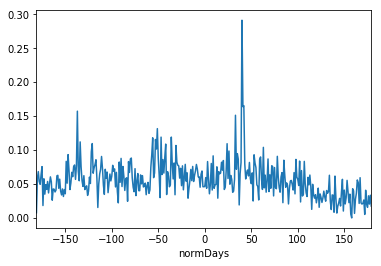

In [130]:
control_review_musician_curve.plot()

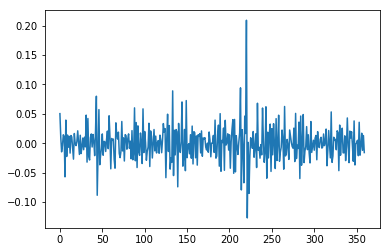

In [131]:
plt.plot(np.diff(control_review_musician_curve))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  


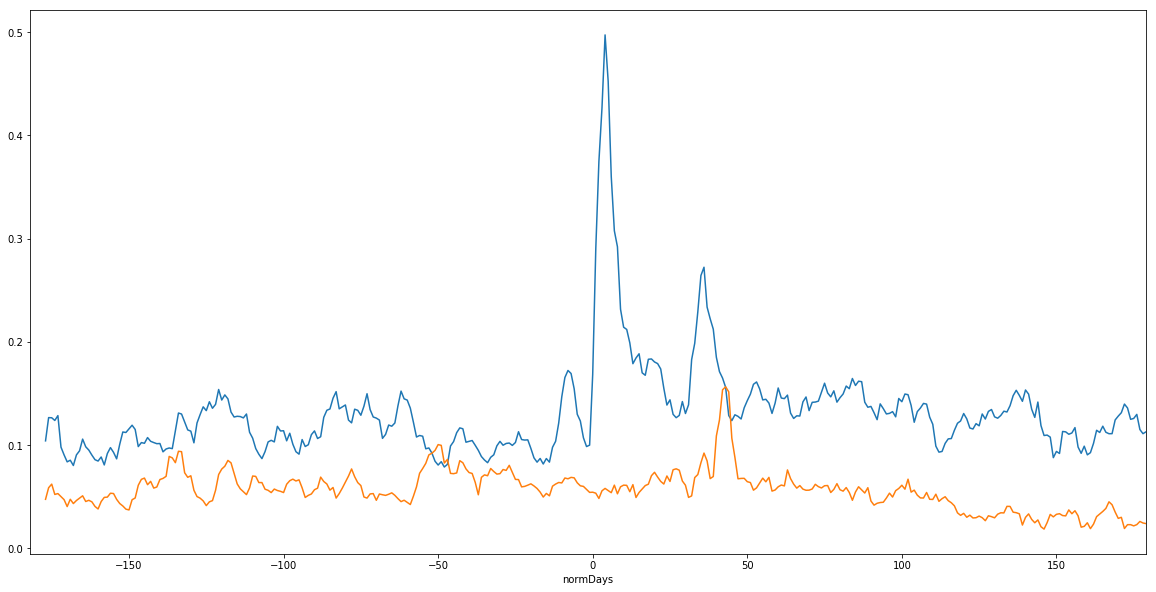

In [132]:
pd.rolling_mean(subject_review_musician_curve,5).plot(figsize=(20,10))
pd.rolling_mean(control_review_musician_curve,5).plot(figsize=(20,10))

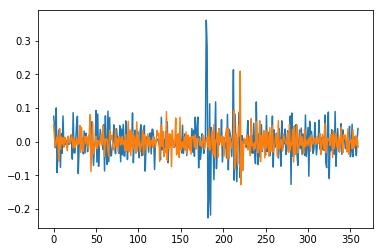

In [133]:
plt.plot(np.diff(subject_review_musician_curve))
plt.plot(np.diff(control_review_musician_curve))

In [134]:
_, p_musician = stats.ttest_ind(subject_review_musician,control_review_musician,axis=1,equal_var=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


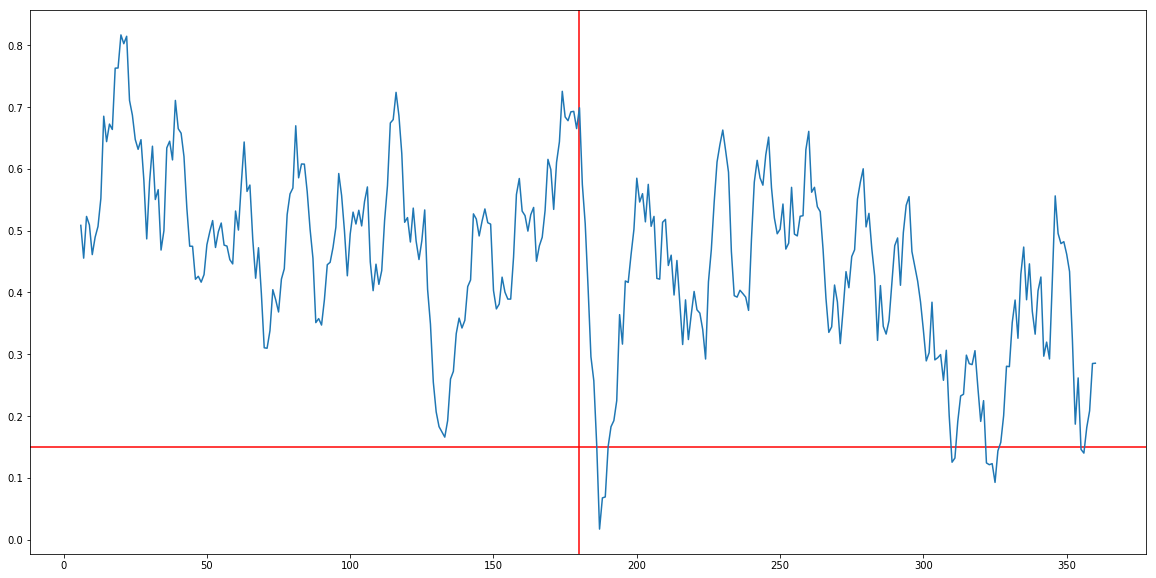

In [149]:
plt.figure(figsize=(20,10))
plt.axhline(y=0.15, color='red')
plt.axvline(x=180, color='red')
#plt.yticks(np.arange(0, 0.15, 0.010))
plt.plot(pd.rolling_mean(p_musician, 7))
#plt.plot(p)
x1,x2,y1,y2 = plt.axis()
#plt.axis((x1,x2,0,0.2))
plt.show()

### 3.3.4 Particular case (famous death)

### Paul Walker

In [136]:
paul_walker_review = AggAllNormDays(df_actor_subject,scalingReviewFilm,[("paul walker","2013-11-30")],10,10)

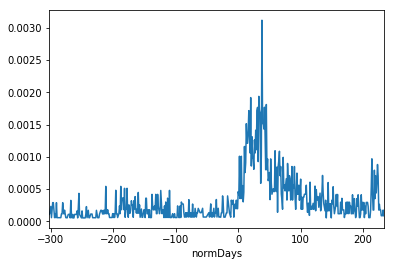

In [137]:
paul_walker_review.plot()

### Heath Ledger

In [138]:
heath_ledger_review = AggAllNormDays(df_actor_subject,scalingReviewFilm,[("heath ledger","2008-01-22")],10,10)

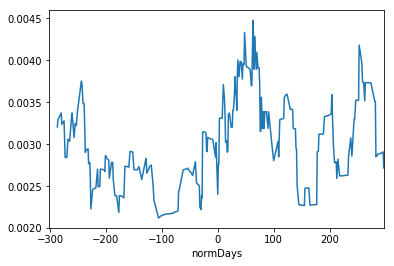

In [139]:
heath_ledger_review.rolling(window=10,center=False).mean().plot()

### Whitney Houston

In [142]:
amy_winehouse_review = AggAllNormDays(df_music_subject,scalingReviewMusic,[("amy winehouse","2011-07-23")],10,10)

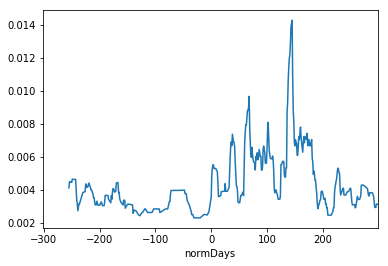

In [143]:
amy_winehouse_review.rolling(window=10,center=False).mean().plot()

In [140]:
whitney_houston_review = AggAllNormDays(df_music_subject,scalingReviewMusic,[("whitney houston","2012-02-11")],10,10)

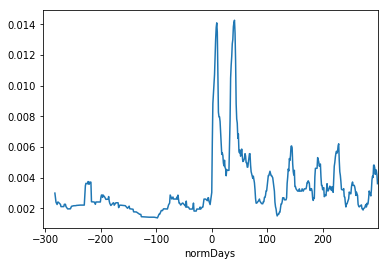

In [141]:
whitney_houston_review.rolling(window=10,center=False).mean().plot()

# 4. Results and Conclusion